In [21]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkFiles
import pandas as pd
import numpy as np
import requests
from IPython.display import HTML
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling, LongformerForMaskedLM,LongformerTokenizer
from datasets import Dataset


# Problem:
We need to train a NLP model on sets financial data in order for it to predict the sentiment of financial data


For this task, We want to use the BERT model, it's flexibility and popularity make it an obvious choice for sentiment analysis.
Because of BERT's popularity, it has high support in case we run into any problems training the model.


## Data:
Our Data will be sourced from Hugging Face and Kaggle and the goal of the data will be to provide BERT with the following qualities:

-An understanding of key words used in Human Emotional intelligence
-Market Volatility
-Financial Vocabulary
-Understanding of the impact financial news has on financial markets

Basically, if BERT were a person it would be an English major looking to become a stock trader.

Our data should reflect our goals, therefore the data we will use to match these goals will be:
## Financial Vocabulary:
### [Investopedia embeddings](https://huggingface.co/datasets/FinLang/investopedia-embedding-dataset)

## Human Emotional Intelligence/Market Volatility:
### [Stock Market Tweets](https://huggingface.co/datasets/mjw/stock_market_tweets)

## Financial News Impact
### [Reuters Financial News](https://huggingface.co/datasets/danidanou/Reuters_Financial_News)


## Emotional Intelligence:
### [Emotions Dataset](https://huggingface.co/datasets/boltuix/emotions-dataset)



In [22]:
#Test run with Reuters dataset

spark = SparkSession.builder.appName("ReutersNews").getOrCreate()
dataset = "danidanou/Reuters_Financial_News"

iframe_html = """
<iframe src="https://huggingface.co/datasets/{dataset}/embed/viewer" width="80%" height="560px"></iframe>
""".format(dataset=dataset)
display(HTML(iframe_html))

In [23]:
#Loading Reuters Data into Spark

HUGGING_FACE_PARQUET_API = "https://huggingface.co/api/datasets/{dataset}/parquet"
r = requests.get(HUGGING_FACE_PARQUET_API.format(dataset=dataset))

train_parquet_files = r.json()['default']['train']

for url in train_parquet_files:
    spark.sparkContext.addFile(url)

df = spark.read.parquet(SparkFiles.getRootDirectory() + "/*.parquet")

25/06/02 17:39:15 WARN SparkContext: The path https://huggingface.co/api/datasets/danidanou/Reuters_Financial_News/parquet/default/train/0.parquet has been added already. Overwriting of added paths is not supported in the current version.


In [24]:
print(f"Shape of the dataset: {df.count()}, {len(df.columns)}")

Shape of the dataset: 105359, 7


In [25]:
df.show(n=10)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+
|            Headline|         Journalists|                Date|                Link|             Summary|             Article|__index_level_0__|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+
|Hitachi, GE boost...|                  []|Mon Nov 13, 2006 ...|http://www.reuter...| TOKYO - Hitachi ...| The move comes a...|                0|
|Volvo to cut 1,00...|                  []|Mon Nov 13, 2006 ...|http://www.reuter...| STOCKHOLM - Truc...| After years of s...|                1|
|European banks hi...|      [Andrew Hurst]|Mon Nov 13, 2006 ...|http://www.reuter...| ZURICH, Nov 13 (...| Since adopting I...|                2|
|Hitachi, GE to fo...|    [Mayumi Negishi]|Mon Nov 13, 2006 ...|http://www.reuter...| TOKYO - Japan's ...| The partnership .

In [26]:
from pyspark.sql.functions import length
df = df.withColumn("Article_length", length("Article"))

df.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+
|summary|            Headline|                Date|                Link|             Summary|             Article| __index_level_0__|    Article_length|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+
|  count|              105359|              105359|              105359|              105359|              105359|            105359|            105359|
|   mean|                null|                null|                null|                null|                null| 53243.31900454636|2773.1103275467685|
| stddev|                null|                null|                null|                null|                null|30733.590297559498|1837.7687900808983|
|    min|"A lot hangs" on ...|Fri Apr 1, 2011 1...|http://www.reuter...|          

/Users/cristianzuniga/Library/Python/3.10/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 2400x600 with 0 Axes>

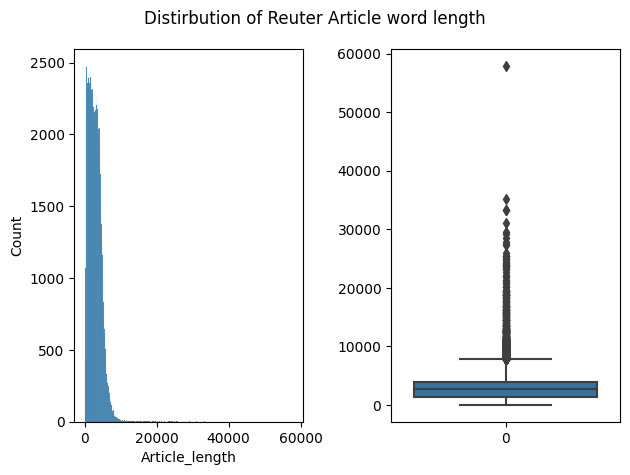

In [27]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(24,6))

fig, axs = plt.subplots(ncols=2)


article_length_series = df.select("Article_length").toPandas().squeeze()


fig.suptitle('Distirbution of Reuter Article word length')

sn.histplot(data=article_length_series, ax=axs[0])

sn.boxplot(data=article_length_series, ax=axs[1])
plt.tight_layout()
plt.show()


In [28]:
print(article_length_series.describe())

print()
print(f"Word skew: {article_length_series.skew()}")
print(f"Word kurtosis: {article_length_series.kurtosis()}")
print(f"IQR {article_length_series.quantile(.75) - article_length_series.quantile(.25)}")

count    105359.000000
mean       2773.110328
std        1837.768790
min           0.000000
25%        1351.000000
50%        2592.000000
75%        3900.000000
max       57887.000000
Name: Article_length, dtype: float64

Word skew: 1.9676235918977563
Word kurtosis: 20.16400051063863
IQR 2549.0


## (5/29/25)

What I'm having issues with is how we can train the model on multiple datasets. We want our model to perform better as it consumes more data in the domain but we risk labels not having the same meaning across datasets. We need a way to remedy this before going forward.

As for model evaluation as the number of datasets increases, we'll use the following methodology:
1. Test model on test slice of previously trained dataset (could be randomly selected or not)
2. Train model on particular dataset
3. Reevaluate model based on test from previously trained dataset(s)
4. Evaluate based on past performace. Did the model improve, did it get worse, any substantial changes?


We know this type of model is possible because OpenAI implements it. However, their methodology and if the models are even tested for performance are unknown.

[Implementation of FinBERT](https://arxiv.org/pdf/1908.10063)

Can use the Paper above as a north star for training our model.

### Plan:
We can use the HuggingFace pretrained BERT, further pretrain it as a language model on the corpus above, and use the reuters dataset as our classification training/testing. 
We'll compare it to FinBERT based on the same metrics used in the paper above to see if we've achieved comparable or better results.


### First step:

We'll train BERT base on the Financial Text database and the Financial news database. We should expect that the distribution of the texts should be different, however we should expect them to be roughly the same length (we'll test this claim).

For now, we'll keep the tweet dataset on the sideline. I'm having problems on how to devise a way to efficently implement training on both really long text and short text. I really value this dataset though, especially since [retail investors have shown to reach $1.5 billion in trading volume in a week](https://irlaw.umkc.edu/faculty_works/928/).

(6/2/25) Update
We need some way to truncate our text since most of our tokens will be over the 512 token limit required for BERT. We'll truncate the middle of the text and extract the 512 tokens and compare the results with a long range tokenizer like Longformer


In [29]:
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model = LongformerForMaskedLM.from_pretrained("allenai/longformer-base-4096")


In [30]:
text_sample = df.sample(False, .05).toPandas()
text_sample = text_sample[text_sample['Article_length'] != 0].drop(columns=['__index_level_0__'])
text_sample = Dataset.from_pandas(text_sample)
text_sample = text_sample.flatten()


In [31]:
def preprocess_function(examples):
    return tokenizer([" ".join(x) for x in examples["Article"]])

token_sample = text_sample.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=text_sample.column_names
    )

Map (num_proc=4):   0%|          | 0/5296 [00:00<?, ? examples/s]

In [32]:

collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)
# Training Arguments
training_args = TrainingArguments(
    output_dir="./longformer-mlm",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,  # Adjust based on GPU memory
    gradient_accumulation_steps=8,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir="./logs",
    logging_steps=100,
    save_steps=10_000,
    save_total_limit=2,
    fp16=True,  # Only if GPU supports it (Ampere/V100+)
    dataloader_num_workers=4,
    max_grad_norm=1.0,
    report_to="tensorboard",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collator,
    train_dataset=token_sample,
)

trainer.train()

ValueError: fp16 mixed precision requires a GPU (not 'mps').